#Import Data dan Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#preprocessing
import string
import ast

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')


In [ ]:
airline_qatar = pd.read_csv('/content/drive/MyDrive/Falcon AI Infographic/Copy of Airline_Qatar_Reviews.csv')
airline_reviews = pd.read_csv('/content/drive/MyDrive/Falcon AI Infographic/Copy of Airline_Reviews.csv')
customer_loyalty = pd.read_csv('/content/drive/MyDrive/Falcon AI Infographic/Copy of Customer_Loyalty_Campaign_Flight.csv', encoding='utf-8', delimiter=';')

# Exploratory Data Analysis

## Check for Missing Data

In [ ]:
def missing_check(df):
    wadah = []
    missing = df.isnull().sum()
    per_miss = (missing / len(df)).round(3)
    data_type = df.dtypes
    number_unique = df.nunique()

    result_df = pd.DataFrame({
        "Missing": missing,
        "Percent_Missing": per_miss,
        "Data_Types": data_type,
        "Number_of_unique": number_unique
    })

    result_df = result_df.sort_values(by = "Missing", ascending=False)

    return result_df

missing_check(airline_qatar)

,Missing,Percent_Missing,Data_Types,Number_of_unique
Recommended,1912,0.807,object,1
Aircraft,1352,0.571,object,307
Verified,1351,0.570,float64,2
Date Flown,826,0.349,object,113
Type Of Traveller,825,0.348,object,4
Route,821,0.347,object,1144
Rating,475,0.201,float64,10
Max Rating,475,0.201,float64,1
Unnamed: 0,474,0.200,float64,1895
Date Published,474,0.200,object,1346


## Airline Reviews: Rating Distribution

<Axes: xlabel='Rating', ylabel='count'>

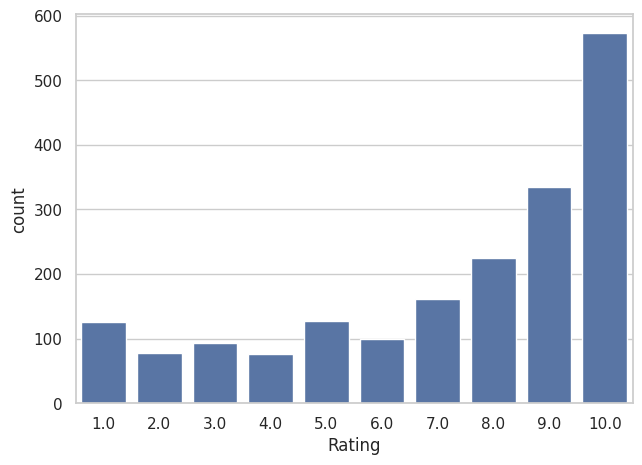

In [ ]:
#countplot airline_qatar['Rating']
sns.countplot(x='Rating', data=airline_qatar)

In [ ]:
df = airline_qatar.copy()

In [ ]:
df['Date Published'] = pd.to_datetime(df['Date Published'])

## Average Rating based on Seat Type

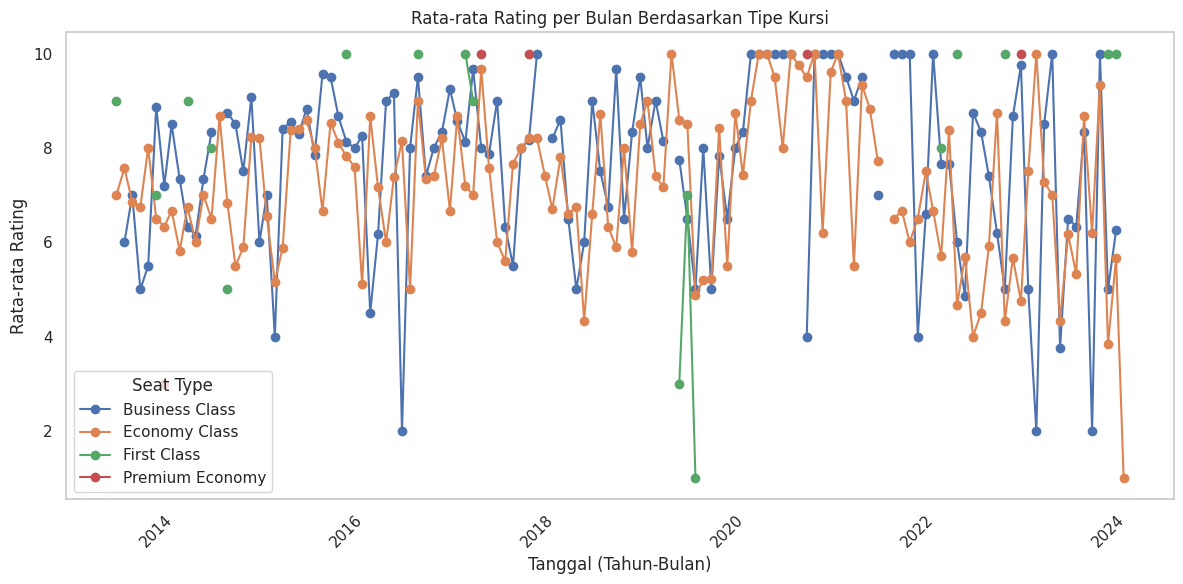

In [ ]:
# Ekstraksi tahun dan bulan dari Date Published
df['year_month'] = pd.to_datetime(df['Date Published']).dt.to_period('M')

# Menghitung rata-rata rating per bulan untuk setiap Seat Type
average_rating = df.groupby(['year_month', 'Seat Type'])['Rating'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 6))
for seat_type in average_rating.columns:
    plt.plot(average_rating.index.to_timestamp(), average_rating[seat_type], marker='o', label=seat_type)

# Menambahkan label dan judul
plt.xlabel('Tanggal (Tahun-Bulan)')
plt.ylabel('Rata-rata Rating')
plt.title('Rata-rata Rating per Bulan Berdasarkan Tipe Kursi')
plt.legend(title='Seat Type')
plt.grid()
plt.xticks(rotation=45)

# Menampilkan plot
plt.tight_layout()
plt.show()


## Average Monthly Rating

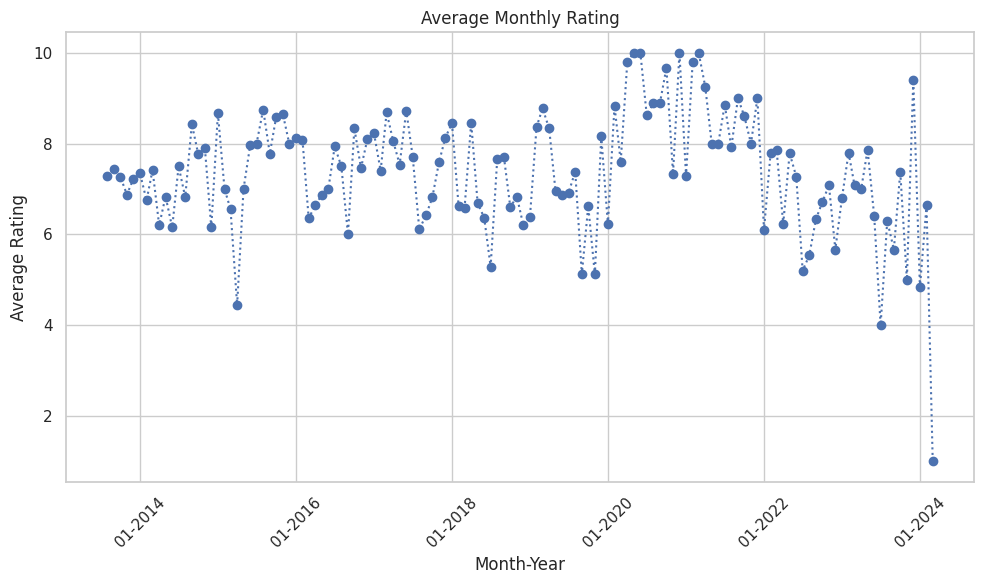

In [ ]:
# Drop rows with NaT values in 'Date Published' or 'Rating'
df = df.dropna(subset=['Date Published', 'Rating'])

# Convert the 'Date Published' column to datetime format
df['Date Published'] = pd.to_datetime(df['Date Published'], errors='coerce')

# Tambahkan kolom untuk Tahun dan Bulan
df['Year'] = df['Date Published'].dt.year
df['Month'] = df['Date Published'].dt.month

# Kelompokkan data berdasarkan Year dan Month, lalu hitung rata-rata rating
monthly_avg_rating = df.groupby(['Year', 'Month'])['Rating'].mean().reset_index()

# Buat kolom datetime dari Year dan Month untuk digunakan sebagai x-axis
monthly_avg_rating['Date'] = pd.to_datetime(monthly_avg_rating[['Year', 'Month']].assign(Day=1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_rating['Date'], monthly_avg_rating['Rating'], linestyle=':', marker='o')
plt.title('Average Monthly Rating')
plt.xlabel('Month-Year')
plt.ylabel('Average Rating')

# Format x-axis as Month-Year
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y'))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
monthly_avg_rating

,Year,Month,Rating,Date
0,2013,8,7.285714,2013-08-01
1,2013,9,7.444444,2013-09-01
2,2013,10,7.272727,2013-10-01
3,2013,11,6.875000,2013-11-01
4,2013,12,7.222222,2013-12-01
...,...,...,...,...
123,2023,11,5.000000,2023-11-01
124,2023,12,9.400000,2023-12-01
125,2024,1,4.833333,2024-01-01
126,2024,2,6.636364,2024-02-01


## Most Frequent Words in Airline Reviews

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


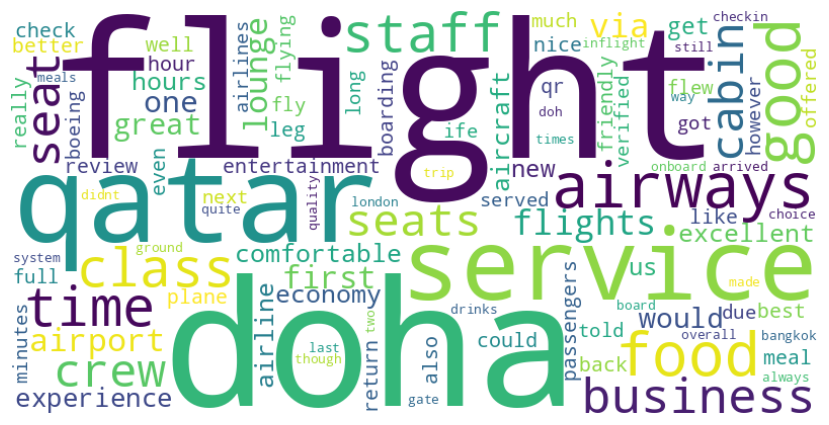

In [ ]:
# Ensure nltk stopwords are downloaded
nltk.download('stopwords')

# Load the stopwords
stop_words = set(stopwords.words('english'))

# Preprocessing function for cleaning text
def clean_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and filter out stop words
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return words  # Return as a list of words for counting

# Assuming df['Review Body'] has the airline reviews
# Drop NaN values in the 'Review Body' column
reviews = df['Review Body'].dropna()

# Preprocess all reviews and flatten the list of words
all_words = [word for review in reviews.apply(clean_text) for word in review]

# Calculate word frequencies
word_frequencies = Counter(all_words)

# Convert word frequencies to a DataFrame
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Generate the word cloud using the frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='viridis')
wordcloud.generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
word_freq_df.head(20)

,Word,Frequency
0,flight,1768
1,doha,1541
2,qatar,1366
3,service,972
4,airways,853
5,good,835
6,food,770
7,time,650
8,staff,645
9,class,629


# Analysis

### Filter ranking only less than 4

In [ ]:
df_less4 = df[df['Rating'] <= 4]

### Prepocessing

In [ ]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
from nltk import pos_tag
import nltk


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

custom_stop_words = {
    'qatar', 'airways', 'airline', 'plane', 'told', 'would', 'ask',
    'flight', 'passenger', 'next', 'check', 'minute', 'hour', 'crew'
}
stop_words.update(custom_stop_words)


def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def clean_text(text):
    text = re.sub(r'(?<=\w)-(?=\w)', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)

    words = [
        lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word))
        for word in text.split()
        if word.lower() not in stop_words and len(word) > 2  # Remove stop words and short words
    ]

    return words

df_less4 = df_less4.dropna(subset=['Review Body'])
df_less4['Cleaned_Review'] = df_less4['Review Body'].apply(clean_text)

df_less4['Cleaned_Review_Text'] = df_less4['Cleaned_Review'].apply(lambda x: ' '.join(x))

rating4 = df_less4[['Cleaned_Review_Text', 'Rating', 'Date Published']]

rating4.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Cleaned_Review_Text,Rating,Date Published
0,delay haneda doha cause bit chaos upon arrival...,1.0,2024-03-02
1,convince need pay 1500 add middle name wouldnt...,1.0,2024-02-29
2,sent email receive automatic response email in...,1.0,2024-02-29
9,complaint service product onboard however lose...,4.0,2024-02-14
13,firstly must state three leg journey penang ba...,1.0,2024-01-27


### Most frequent word after prepocessing

In [ ]:
from collections import Counter

# Most frequent word after prepocessing
all_words = [word for tokens in df_less4['Cleaned_Review'] for word in tokens]
word_frequencies = Counter(all_words)
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
word_freq_df.head(10)


,Word,Frequency
2,doha,333
29,seat,262
72,service,164
52,get,145
65,time,135
48,staff,127
66,hour,117
84,airport,107
273,food,94
583,flight,93


### Determining number of topics

Coherence Score for 2 topics: 0.41835503386632056
Coherence Score for 3 topics: 0.41326475325170703
Coherence Score for 4 topics: 0.3896228790605203
Coherence Score for 5 topics: 0.3404070070943609
Coherence Score for 6 topics: 0.3684706846682236
Coherence Score for 7 topics: 0.3881073650566969
Coherence Score for 8 topics: 0.37931131960560516
Coherence Score for 9 topics: 0.37107139846492676
Coherence Score for 10 topics: 0.34773361541165854


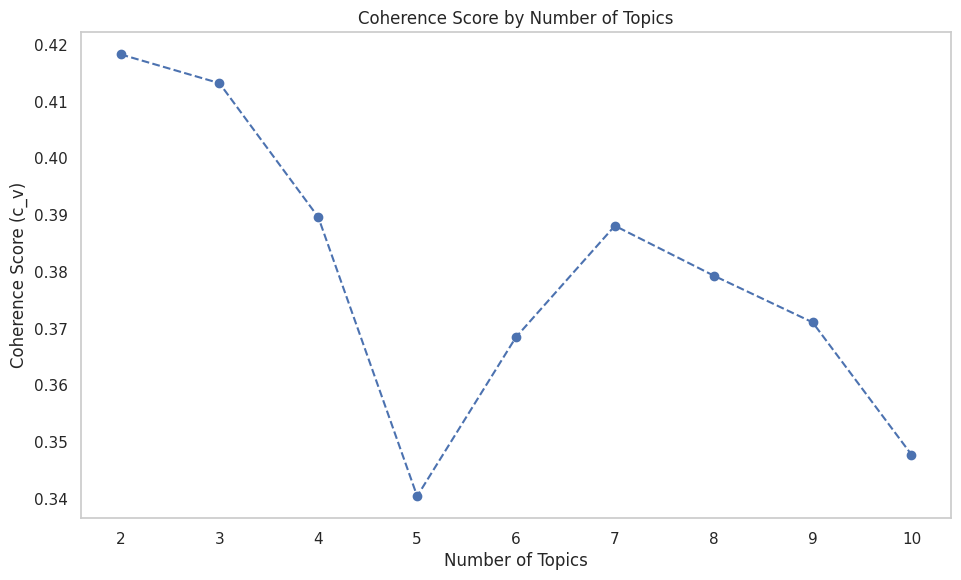

In [ ]:
from gensim.models import CoherenceModel

coherence_scores = []
rating4['tokens'] = rating4['Cleaned_Review_Text'].apply(lambda x: x.split())
dictionary = Dictionary(rating4['tokens'])
dictionary.filter_extremes(no_above=0.4)
bow_corpus = [dictionary.doc2bow(text) for text in rating4['tokens']]

for num_topics in range(2, 11):
    # Train the LDA model
    ldamodel = LdaModel(
        bow_corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=50,
        iterations=600,
        random_state=212,
        alpha='asymmetric',
        eta='auto'
    )

    # Compute the coherence score
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=rating4['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Coherence Score for {num_topics} topics: {coherence_score}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), coherence_scores, marker='o', linestyle='--')
plt.title('Coherence Score by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.grid()
plt.show()

### LDA Model with num of topics = 3

In [ ]:
# Train the LDA model
num_topics = 3
ldamodel = LdaModel(
    bow_corpus,
    num_topics=num_topics,
    id2word=dictionary,
    passes=50,
    iterations=600,
    random_state = 212,
    alpha='asymmetric',
    eta='auto'
)

topics = ldamodel.show_topics(num_topics=num_topics, num_words=20, log=False, formatted=False)

for topic_id, topic in topics:
    print("Topic {}:".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic 0:
Words: ['business', 'staff', 'food', 'class', 'good', 'time', 'one', 'return', 'cabin', 'via', 'serve', 'lounge', 'flight', 'get', 'even', 'leg', 'travel', 'well', 'economy', 'aircraft']
Topic 1:
Words: ['book', 'change', 'get', 'day', 'airport', 'customer', 'call', 'ticket', 'time', 'flight', 'cancel', 'paid', 'email', 'say', 'inform', 'agent', 'contact', 'wait', 'extra', 'refund']
Topic 2:
Words: ['hour', 'delayed', 'get', 'arrive', 'miss', 'wait', 'hotel', 'airport', 'connect', 'luggage', 'take', 'late', 'delay', 'time', 'staff', 'minute', 'passenger', 'doh', 'due', 'connection']


In [ ]:
# Calculate the coherence score for the trained LDA model
coherence_model = CoherenceModel(model=ldamodel, texts=rating4['tokens'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print the coherence score
print("Coherence Score:", coherence_score)

Coherence Score: 0.41326475325170703


### Determining topic based on the highest probability & Visualization

In [ ]:
topic_distributions = [ldamodel.get_document_topics(bow) for bow in bow_corpus]

# Convert topic distributions to a DataFrame
topic_probabilities = []
for doc_topics in topic_distributions:
    doc_dict = {f'Topic_{topic_id}': prob for topic_id, prob in doc_topics}
    # Ensure all topics are represented, even if they have a 0 probability
    for i in range(num_topics):
        if f'Topic_{i}' not in doc_dict:
            doc_dict[f'Topic_{i}'] = 0.0
    topic_probabilities.append(doc_dict)


topic_prob_df = pd.DataFrame(topic_probabilities)


rating4_with_topics = pd.concat([rating4.reset_index(drop=False), topic_prob_df], axis=1)
rating4_with_topics['Topik'] = topic_prob_df.idxmax(axis=1).str.replace('Topic_', '').astype(int)

In [ ]:
rating4_with_topics

,index,Cleaned_Review_Text,Rating,Date Published,tokens,Topic_0,Topic_2,Topic_1,Topik
0,0,delay haneda doha cause bit chaos upon arrival...,1.0,2024-03-02,"[delay, haneda, doha, cause, bit, chaos, upon,...",0.011598,0.983343,0.000000,2
1,1,convince need pay 1500 add middle name wouldnt...,1.0,2024-02-29,"[convince, need, pay, 1500, add, middle, name,...",0.694417,0.000000,0.296905,0
2,2,sent email receive automatic response email in...,1.0,2024-02-29,"[sent, email, receive, automatic, response, em...",0.000000,0.000000,0.993796,1
3,9,complaint service product onboard however lose...,4.0,2024-02-14,"[complaint, service, product, onboard, however...",0.028845,0.011375,0.959780,1
4,13,firstly must state three leg journey penang ba...,1.0,2024-01-27,"[firstly, must, state, three, leg, journey, pe...",0.989034,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...
229,2275,flown economy class time past month living doh...,2.0,2014-01-14,"[flown, economy, class, time, past, month, liv...",0.804386,0.000000,0.190490,0
230,2276,flew back delhi 563 6th jan 8hr min delay due ...,4.0,2014-01-14,"[flew, back, delhi, 563, 6th, jan, 8hr, min, d...",0.135349,0.857714,0.000000,2
231,2288,dec 2013 002 lhr doh 832 doh bkk dec board fli...,3.0,2014-01-08,"[dec, 2013, 002, lhr, doh, 832, doh, bkk, dec,...",0.714711,0.194788,0.090501,0
232,2296,london doha business new airbus attendant engl...,3.0,2013-12-25,"[london, doha, business, new, airbus, attendan...",0.988936,0.000000,0.000000,0


In [ ]:
rating4

,Cleaned_Review_Text,Rating,Date Published,tokens
0,delay haneda doha cause bit chaos upon arrival...,1.0,2024-03-02,"[delay, haneda, doha, cause, bit, chaos, upon,..."
1,convince need pay 1500 add middle name wouldnt...,1.0,2024-02-29,"[convince, need, pay, 1500, add, middle, name,..."
2,sent email receive automatic response email in...,1.0,2024-02-29,"[sent, email, receive, automatic, response, em..."
9,complaint service product onboard however lose...,4.0,2024-02-14,"[complaint, service, product, onboard, however..."
13,firstly must state three leg journey penang ba...,1.0,2024-01-27,"[firstly, must, state, three, leg, journey, pe..."
...,...,...,...,...
2275,flown economy class time past month living doh...,2.0,2014-01-14,"[flown, economy, class, time, past, month, liv..."
2276,flew back delhi 563 6th jan 8hr min delay due ...,4.0,2014-01-14,"[flew, back, delhi, 563, 6th, jan, 8hr, min, d..."
2288,dec 2013 002 lhr doh 832 doh bkk dec board fli...,3.0,2014-01-08,"[dec, 2013, 002, lhr, doh, 832, doh, bkk, dec,..."
2296,london doha business new airbus attendant engl...,3.0,2013-12-25,"[london, doha, business, new, airbus, attendan..."


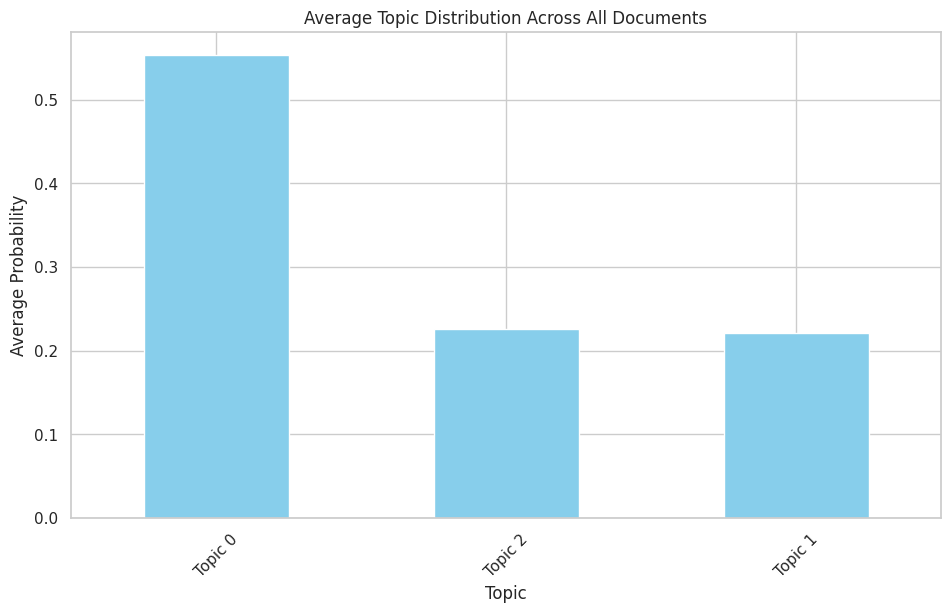

In [ ]:
# Create a DataFrame to hold the topic distribution for each document
topic_distributions = []
for bow in bow_corpus:
    topic_distribution = [prob for _, prob in ldamodel.get_document_topics(bow, minimum_probability=0)]
    topic_distributions.append(topic_distribution)

# Convert the list of topic distributions into a DataFrame
topic_dist_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i}" for i in range(num_topics)])

# Combine with the original DataFrame for reference
df_topic_dist = pd.concat([rating4[['Cleaned_Review_Text', 'Rating']], topic_dist_df], axis=1)

# Visualize the average distribution of topics across all documents using a bar plot
average_topic_dist = topic_dist_df.mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
average_topic_dist.plot(kind='bar', color='skyblue')
plt.title("Average Topic Distribution Across All Documents")
plt.xlabel("Topic")
plt.ylabel("Average Probability")
plt.xticks(rotation=45)
plt.show()